In [39]:
# TODO - find a way to make this install the poetry enviorment
import os
os.chdir("C:\\Users\yuvmi\PycharmProjects\SequenceModelLab")
!poetry install

Installing dependencies from lock file

No dependencies to install or update


In [40]:
import numpy as np

In [41]:
import os
import glob
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter, PillowWriter

## Reading result logs

In [42]:
class Result():
    
    def __init__(self, data):
        losses = np.array([l.entity for l in data["loss"]])
        l_epochs = np.array([l.epoch_logged for l in data["loss"]])
        if len(losses) == 0:
            self.min_loss = None
            return
        exploded = (np.argmax(losses) == len(losses) - 1)
        min_loss = np.min(losses)
        best_ker = data["kernel"][np.argmin(losses)-1].entity
    
        
        if np.isnan(min_loss):
            self.min_loss = None
        else:
            self.min_loss = min_loss
        self.exploded = exploded
        self.best_ker = best_ker
        self.epoch_best_res = np.argmin(losses)
        self.best_A = data["A"][np.argmin(losses)-1].entity
        self.best_B = data["B"][np.argmin(losses)-1].entity
        self.best_C = data["C"][np.argmin(losses)-1].entity
        self.train_len = len(losses)
    
    def __bool__(self):
        return self.min_loss is not None

In [43]:
experiments_results = defaultdict(dict)

In [44]:
#experiment_file_regexs = [r".\results\lag_exp\*",r".\results\lag_exp_long\*"]
experiment_file_regexs = [r".\results\lag_exp\*"]

for experiment_file_regex in experiment_file_regexs:
    for file_path in tqdm(glob.glob(experiment_file_regex)):
        if "filepart" in file_path:
            print(file_path)
            continue
        file_name = os.path.basename(file_path)
        exp_name = "_".join(file_name.split('_')[1:-1])
        exp_num = int(file_name.split('_')[-1])
        if exp_name in experiments_results and exp_num in experiments_results[exp_name]:
            continue
        with open(file_path,"rb") as f:
            data = pickle.load(f)
            result = Result(data)
            if result:
                experiments_results[exp_name][exp_num] = Result(data)
            else:
                print(exp_name,exp_num)

  0%|          | 0/412 [00:00<?, ?it/s]

fssm_bd 6
fssm_bd 66
fssm_ud 10
full_hipo_bdt 10


In [45]:
[k for k in experiments_results.keys()]

['diag_hippo',
 'diag_hippo_disc',
 'fssm_bd',
 'fssm_ud',
 'full_hippo_bdt',
 'full_hippo_disc_bdt',
 'full_hippo_disc_sdt',
 'full_hippo_sdt']

In [46]:
del experiments_results["full_hippo_bdt"][400]

## Analysis

### Analysing loss at different lags

In [47]:
def save_loss_plot(lag_nums, min_losses, exploaded, exp_name,save_path):
    plt.figure()
    plt.plot(lag_nums,min_losses)
    scatter, = plt.plot(lag_nums[exploded],min_losses[exploded],"o", color = "red")
    scatter.set_label('exploded while training')
    scatter, = plt.plot(lag_nums[~exploded],min_losses[~exploded],"o", color = "green")
    scatter.set_label('finished gracefully')
    plt.title(exp_name)
    plt.xlabel("lag")
    plt.ylabel("min train loss")
    plt.legend()
    plt.savefig(save_path)

diag_hippo
diag_hippo_disc
fssm_bd
fssm_ud
full_hippo_bdt
full_hippo_disc_bdt
full_hippo_disc_sdt
full_hippo_sdt


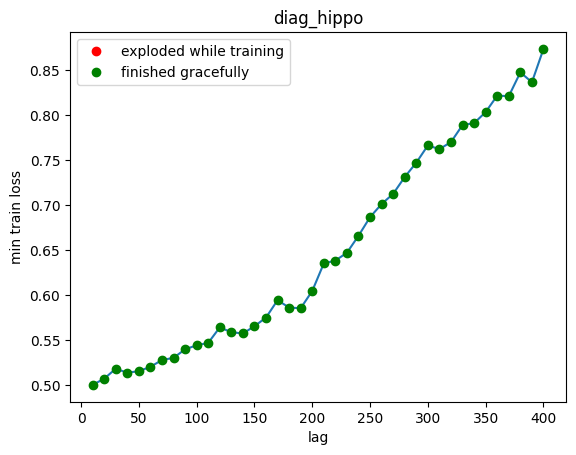

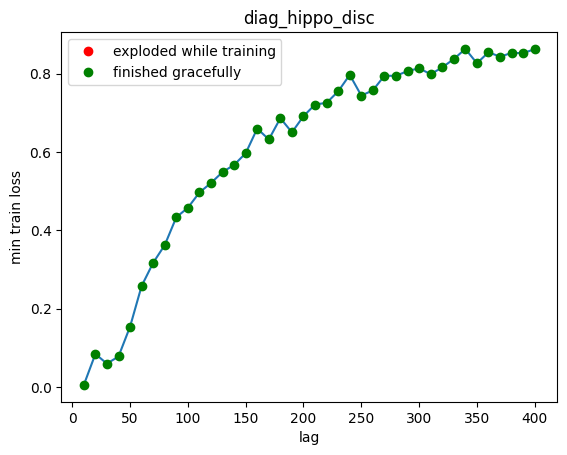

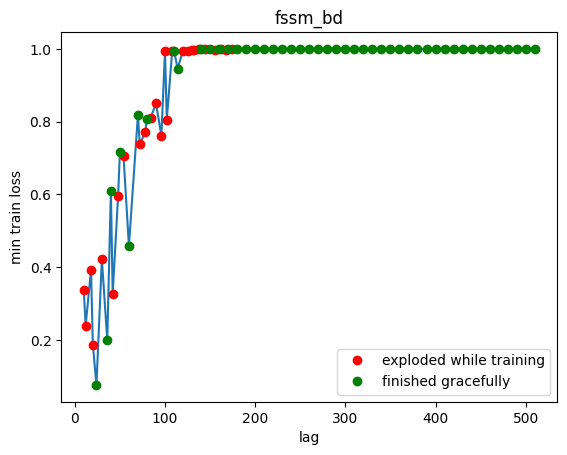

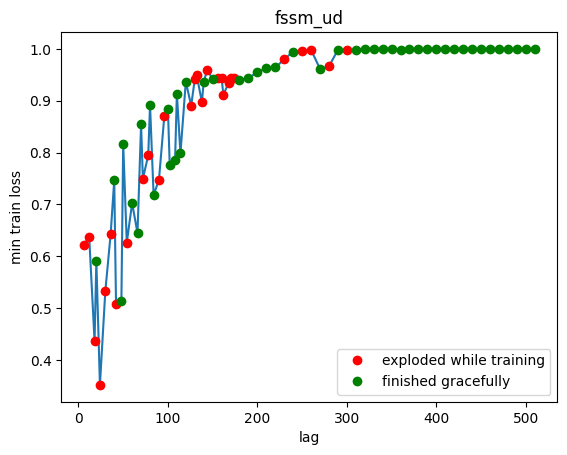

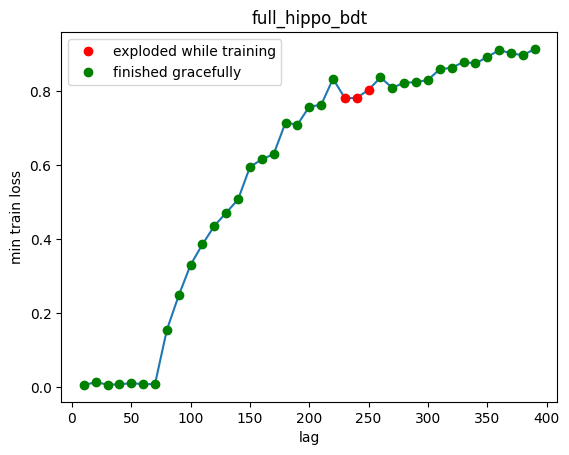

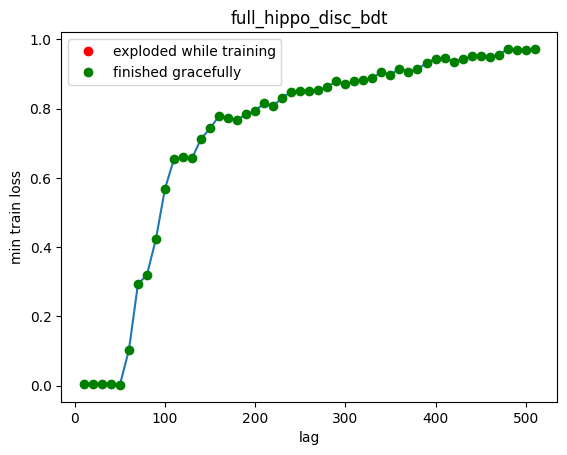

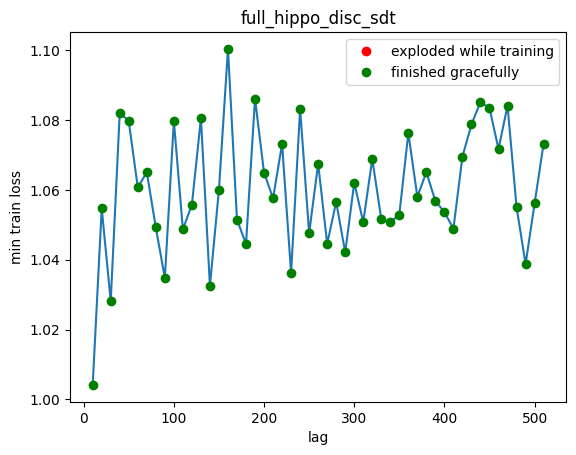

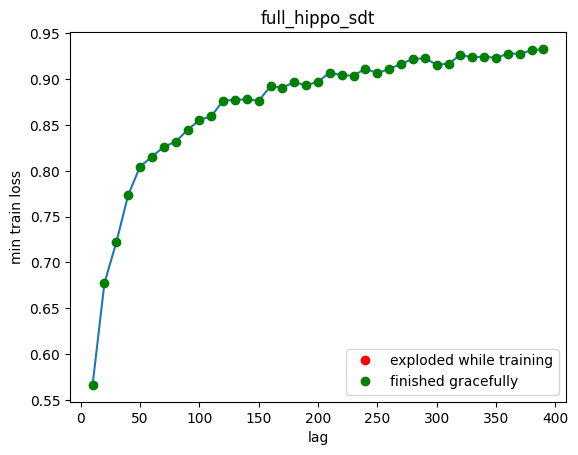

In [48]:
for exp_name in experiments_results.keys():
    print(exp_name)
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    exploded = np.array([experiments_results[exp_name][lag_num].exploded for lag_num in lag_nums])
    save_loss_plot(lag_nums, min_losses, exploded, exp_name,".\\analysis\\lags_different_ssm_model_results\\loss_plot_"+exp_name+".png")

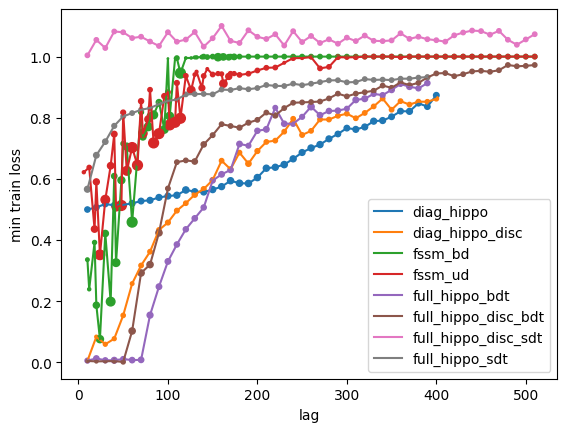

In [49]:
plt.figure()
for exp_name in experiments_results.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    train_len = np.array([experiments_results[exp_name][lag_num].train_len for lag_num in lag_nums])
    plt.plot(lag_nums,min_losses,label = exp_name)
    plt.scatter(lag_nums,min_losses, s=train_len/100)
plt.xlabel("lag")
plt.ylabel("min train loss")
plt.legend()
#plt.savefig(".\\analysis\\lags_different_ssm_model_results\\all_loss_plots.png")

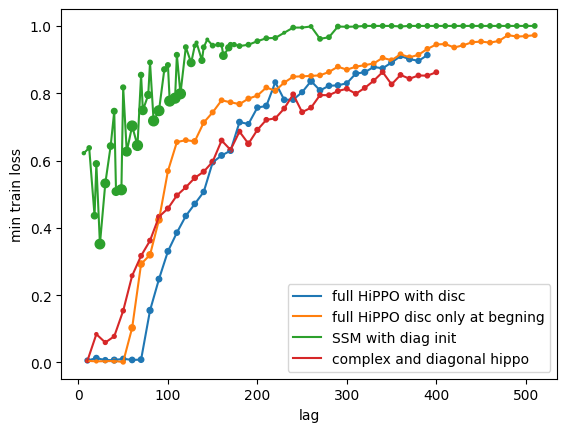

In [51]:
# Specific readable output
plt.figure()
exp_name_to_readable = {
    "full_hippo_bdt":"full HiPPO with disc",
    "full_hippo_disc_bdt":"full HiPPO disc only at begning",
    "fssm_ud":"SSM with diag init",
    "diag_hippo_disc":"complex and diagonal hippo",
}
for exp_name in exp_name_to_readable.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    train_len = np.array([experiments_results[exp_name][lag_num].train_len for lag_num in lag_nums])
    plt.plot(lag_nums,min_losses,label = exp_name_to_readable[exp_name])
    plt.scatter(lag_nums,min_losses, s=train_len/100)
plt.xlabel("lag")
plt.ylabel("min train loss")
plt.legend()

Text(0.5, 1.0, 'lag=300')

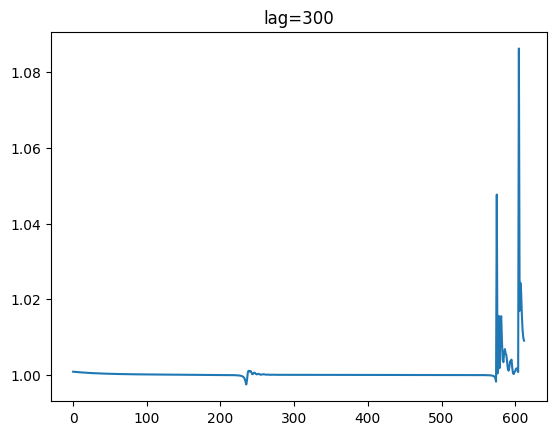

In [98]:
lag = 300
result = get_result_from_file_path(r"C:\Users\yuvmi\PycharmProjects\SequenceModelLab\results\lag_exp\fast_fssm_ud_%d"%(lag))
plt.plot(result.losses[100:-5])
plt.title("lag=%d"%(lag))


### Creating kernel videos

In [99]:
def plot_single_kernel_frame(kernel, lag):
    plt.title("lag=%d"%lag)
    plt.plot(lag,kernel[lag],"o",color = "red")
    plt.plot(kernel)
    ax = plt.gca()
    ax.set_ylim([0, max(np.max(kernel),0.7)])

In [100]:

def make_videos_from_list_of_arrays(arrays, lags, save_path):
    writer = FFMpegWriter(fps=3)
    img = [] # some array of images
    frames = [] # for storing the generated images
    fig = plt.figure()
    with writer.saving(fig, save_path, 100):
        for i in tqdm(range(len(arrays))):
            fig.clear()
            plot_single_kernel_frame(arrays[i], lags[i])
            writer.grab_frame()



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

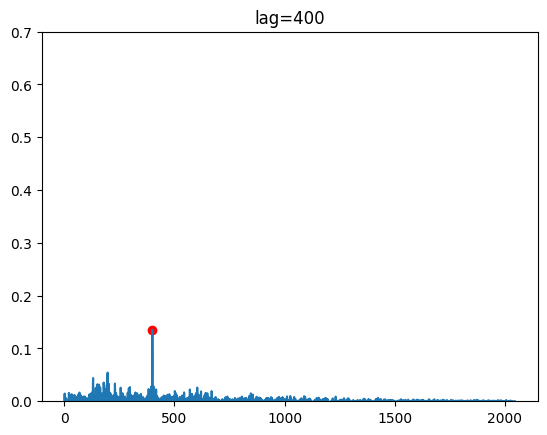

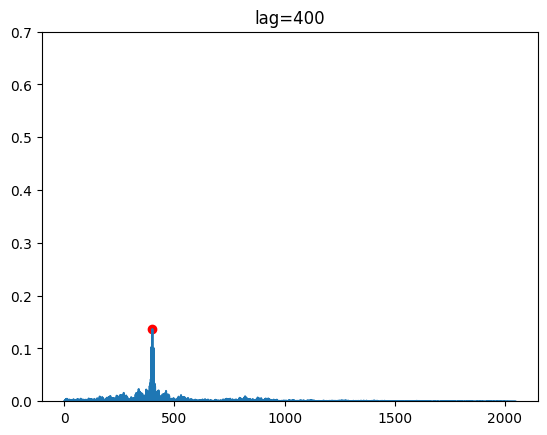

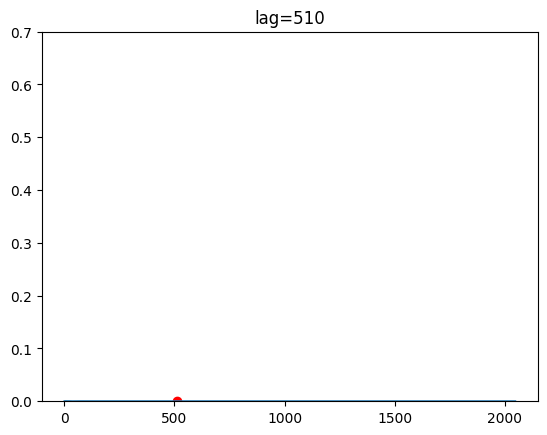

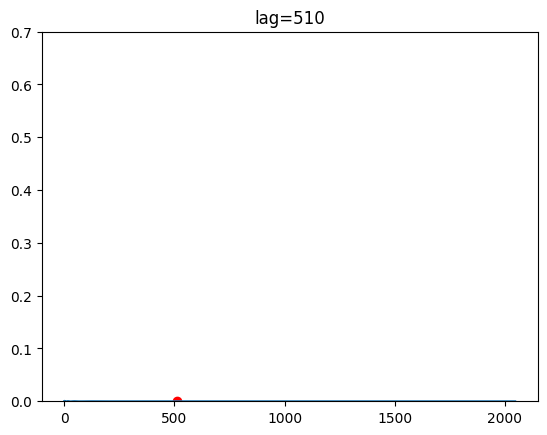

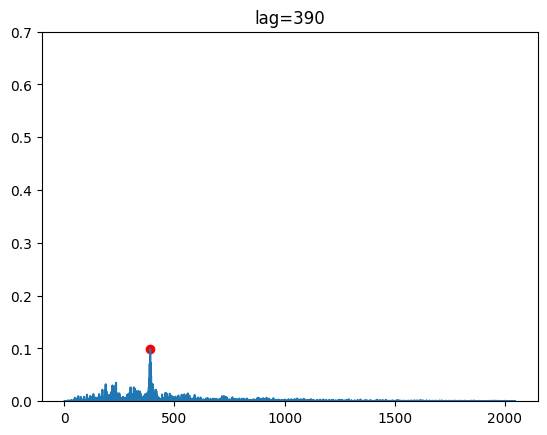

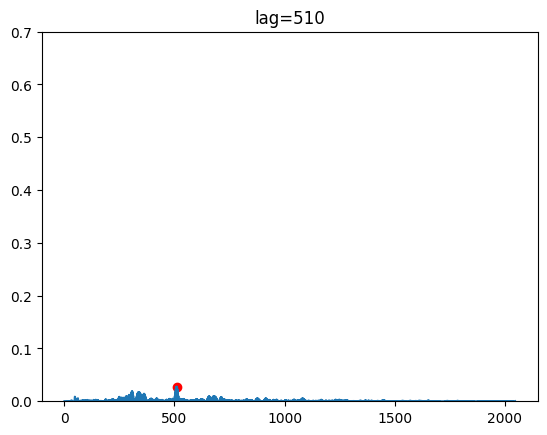

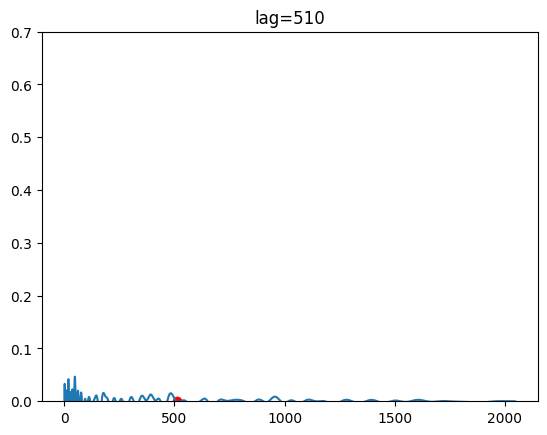

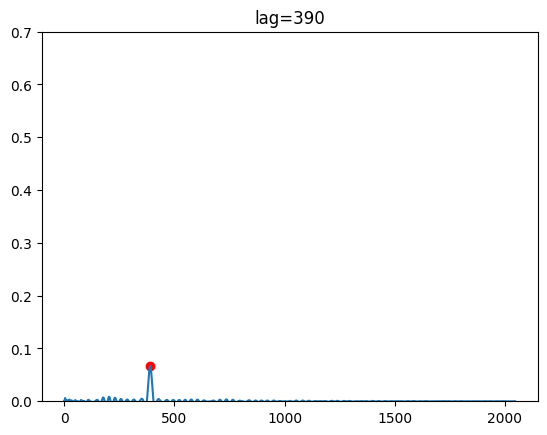

In [101]:
for exp_name in tqdm(experiments_results.keys()):
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    ordered_kernels = np.array([experiments_results[exp_name][lag_num].best_ker for lag_num in lag_nums])
    make_videos_from_list_of_arrays(ordered_kernels, lag_nums,".\\analysis\\lags_different_ssm_model_results\\kernel_vid_"+exp_name+".mp4")

## End state

In [125]:
def get_sorted_eigen(matrix):
    if matrix.ndim == 1:
        e = matrix
    else:
        e = np.linalg.eig(matrix)[0]
    e = np.abs(e)
    return np.sort(e)

In [132]:
def get_sorted_eigen_complex(matrix):
    if matrix.ndim == 1:
        e = matrix
    else:
        e = np.linalg.eig(matrix)[0]
    e = e[np.argsort(np.abs(e))]
    return e

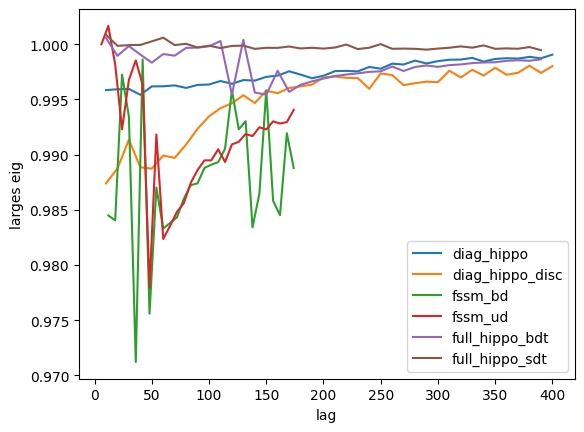

In [192]:
plt.figure()
for exp_name in experiments_results.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
    highes_e = [get_sorted_eigen(A)[-1] for A in best_As]
    plt.plot(lag_nums,highes_e,label = exp_name)
plt.xlabel("lag")
plt.ylabel("larges eig")
plt.legend()
plt.savefig(".\\analysis\\lags_different_ssm_model_results\\eig_dyn.png")

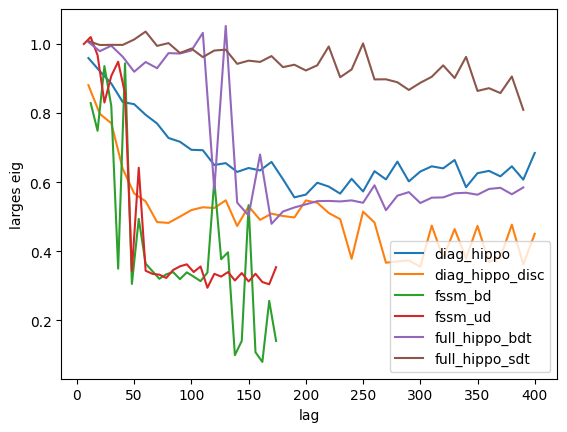

In [193]:
plt.figure()
for exp_name in experiments_results.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
    highes_e = [get_sorted_eigen(A)[-1] for A in best_As]
    plt.plot(lag_nums,highes_e**lag_nums,label = exp_name)
plt.xlabel("lag")
plt.ylabel("larges eig")
plt.legend()
plt.savefig(".\\analysis\\lags_different_ssm_model_results\\eig_dyn_relative.png")

In [137]:
# plt.figure()
# for exp_name in experiments_results.keys():
#     lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
#     lag_nums.sort()
#     best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
#     highes_e = [get_sorted_eigen_complex(A)[-1].imag for A in best_As]
#     plt.plot(lag_nums,highes_e,label = exp_name)
# plt.xlabel("lag")
# plt.ylabel("larges eig")
# plt.legend()

In [138]:
# plt.figure()
# for exp_name in experiments_results.keys():
#     lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
#     lag_nums.sort()
#     best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
#     highes_e = [get_sorted_eigen_complex(A)[-1].real for A in best_As]
#     plt.plot(lag_nums,highes_e,label = exp_name)
# plt.xlabel("lag")
# plt.ylabel("larges eig")
# plt.legend()

## Ploting dynamics

In [59]:
class FullResult():
    
    def __init__(self, data):
        losses = np.array([l.entity for l in data["loss"]])
        l_epochs = np.array([l.epoch_logged for l in data["loss"]])
        if len(losses) == 0:
            self.min_loss = None
            return
        exploded = (np.argmax(losses) == len(losses) - 1)
        min_loss = np.min(losses)
        best_ker = data["kernel"][np.argmin(losses)-1].entity
        
        
        
        if np.isnan(min_loss):
            self.min_loss = None
        else:
            self.min_loss = min_loss
            
        self.exploded = exploded
        self.best_ker = best_ker
        self.epoch_best_res = np.argmin(losses)
        self.As = [l.entity for l in data["A"]]
        self.Bs = [l.entity for l in data["B"]]
        self.Cs = [l.entity for l in data["C"]]
        self.kernels = [l.entity for l in data["kernel"]]
        self.epochs = np.array([l.epoch_logged for l in data["loss"]])
        self.losses = losses
    
    def __bool__(self):
        return self.min_loss is not None

In [60]:
def get_sorted_eigen(matrix):
    if matrix.ndim == 1:
        e = matrix
    else:
        e = np.linalg.eig(matrix)[0]
    e = np.abs(e)
    return np.sort(e)

In [61]:
def get_result_from_file_path(file_path): 
    with open(file_path,"rb") as f:
        data = pickle.load(f)
        result = FullResult(data)
        if result:
            return result
        else:
            return "None"

In [62]:
def draw_dynamics(exp_name, exp_num):
    filepath = '.\\results\\lag_exp\\fast_{exp_name}_{exp_num}'.format(exp_name=exp_name,
                                                                       exp_num=exp_num)
    print(filepath)
    r = get_result_from_file_path(filepath)
    
    eig = []
    for A in tqdm(r.As):
        eig.append(get_sorted_eigen(A))
    eig = np.array(eig)
    Cs = np.abs(np.array(r.Cs)[:,0,:])
    print(np.array(r.Cs).shape)

    plt.figure()
    plt.plot(r.epochs,eig[:,:5])
    plt.figure()
    plt.plot(r.epochs,eig[:,-5:])
    
    plt.figure()
    plt.plot(r.epochs,Cs)
    

In [63]:
filepath = '.\\results\\lag_exp\\fast_{exp_name}_{exp_num}'.format(exp_name="full_hippo_bdt",
                                                                       exp_num=120)
print(filepath)
r = get_result_from_file_path(filepath)

.\results\lag_exp\fast_full_hippo_bdt_120


In [115]:
[e for e in experiments_results.keys()]

['diag_hippo',
 'diag_hippo_disc',
 'fssm_bd',
 'fssm_ud',
 'full_hippo_bdt',
 'full_hippo_sdt']

.\results\lag_exp\fast_full_hippo_bdt_120


  0%|          | 0/1366 [00:00<?, ?it/s]

(1366, 1, 128)


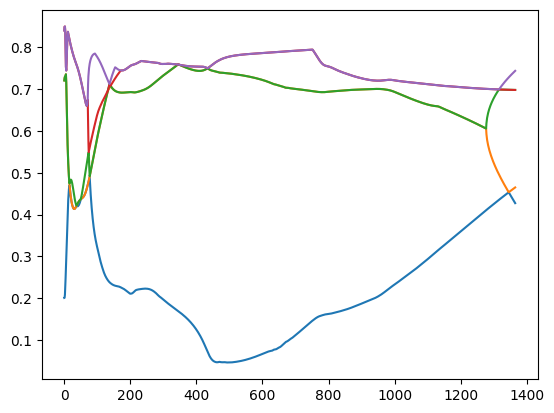

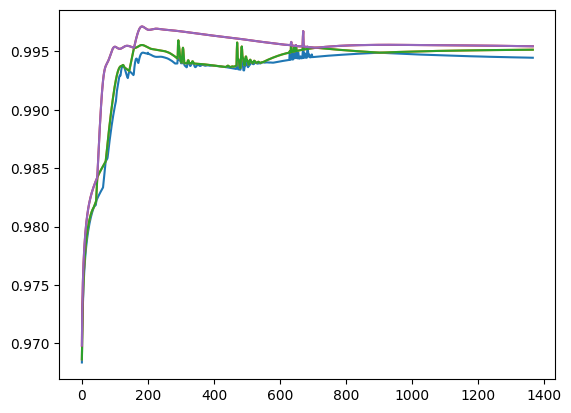

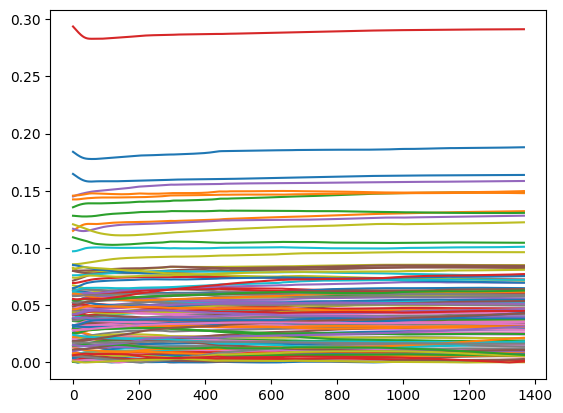

In [116]:
draw_dynamics("full_hippo_bdt",120)

.\results\lag_exp\fast_fssm_ud_120


  0%|          | 0/1895 [00:00<?, ?it/s]

(1895, 1, 128)


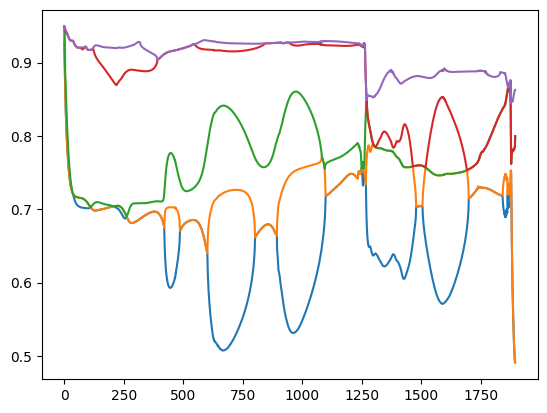

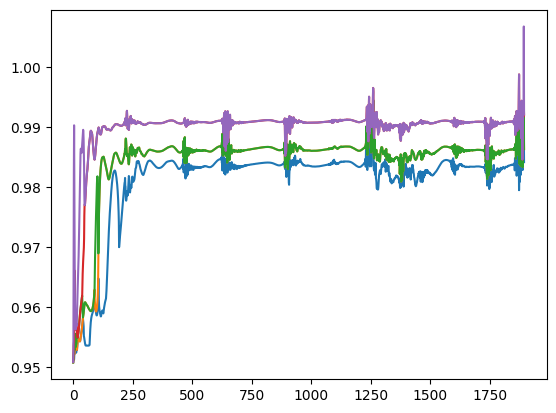

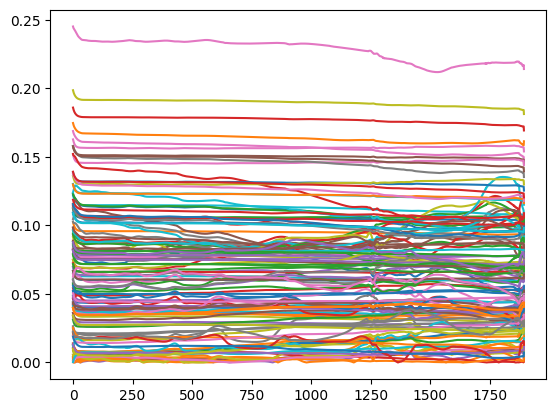

In [117]:
draw_dynamics("fssm_ud",120)

In [ ]:
draw_dynamics("full_hippo_bdt",180)

In [119]:
draw_dynamics("fssm_ud",180)

.\results\lag_exp\fast_fssm_ud_200


FileNotFoundError: [Errno 2] No such file or directory: '.\\results\\lag_exp\\fast_fssm_ud_200'

## Controlabilty

In [54]:
def get_full_obs_eigenvalues(A, C):
    n = A.shape[0]
    controlabilty_matrix = np.zeros((n, n))
    observabilty_matrix = np.zeros((n, n))
    #controlabilty_matrix_row_norm = np.zeros(n)
    
    for i in range(n):
        a_pow_i = np.linalg.matrix_power(A, i)
        #a_pow_i_times_b = a_pow_i.dot(B.transpose())
        c_times_a_pow_i = C.dot(a_pow_i)
        #controlabilty_matrix[:, i] = a_pow_i_times_b.reshape(-1)
        observabilty_matrix[i,:] = c_times_a_pow_i.reshape(-1)
        #controlabilty_matrix_row_norm[i] = np.linalg.norm(a_pow_i_times_b)
        # print(hankel_matrix)
    #u, s, vh = np.linalg.svd(controlabilty_matrix)
    #parcital_s = C.dot(u)

    #parcital_s = s*s
    #self.controlabilty_eigenval_arr.append(parcital_s)

    u, s, vh = np.linalg.svd(observabilty_matrix)
    parcital_s = s * s
    #self.observabilty_eigenval_arr.append(parcital_s)
    #self.controlabilty_row_norm.append(controlabilty_matrix_row_norm)
    return np.sort(np.abs(parcital_s))

In [64]:
def get_diag_obs_eigenvalues(A, C):
    n = A.shape[0]
    controlabilty_matrix = np.zeros((n, n))
    observabilty_matrix = np.zeros((n, n))
    #controlabilty_matrix_row_norm = np.zeros(n)
    
    for i in range(n):
        a_pow_i = A**i
        #a_pow_i_times_b = a_pow_i.dot(B.transpose())
        c_times_a_pow_i = C * a_pow_i
        observabilty_matrix[i,:] = c_times_a_pow_i.reshape(-1)
        #controlabilty_matrix_row_norm[i] = np.linalg.norm(a_pow_i_times_b)
        # print(hankel_matrix)
    #u, s, vh = np.linalg.svd(controlabilty_matrix)
    #parcital_s = C.dot(u)

    #parcital_s = s*s
    #self.controlabilty_eigenval_arr.append(parcital_s)

    u, s, vh = np.linalg.svd(observabilty_matrix)
    parcital_s = s * s
    #self.observabilty_eigenval_arr.append(parcital_s)
    #self.controlabilty_row_norm.append(controlabilty_matrix_row_norm)
    return np.sort(np.abs(parcital_s))

In [65]:
def get_obs_eigenvalues(A,C):
    if A.ndim == 2:
        return get_full_obs_eigenvalues(A,C)
    else:
        return get_diag_obs_eigenvalues(A,C)

In [92]:
def draw_controlabilty_dynamics(exp_name, exp_num):
    filepath = '.\\results\\lag_exp\\fast_{exp_name}_{exp_num}'.format(exp_name=exp_name,
                                                                       exp_num=exp_num)
    r = get_result_from_file_path(filepath)
    
    obs = []
    for i in tqdm(range(len(r.As))):
        obs.append(get_obs_eigenvalues(r.As[i],r.Cs[i]))
        #if (i % 100) == 99:
        #    plt.figure()
        #    plt.plot(r.epochs[:len(obs)],np.array(obs))
        #    plt.show()
    obs = np.array(obs)
    plt.figure()
    plt.plot(r.epochs,obs)

    

  0%|          | 0/1366 [00:00<?, ?it/s]

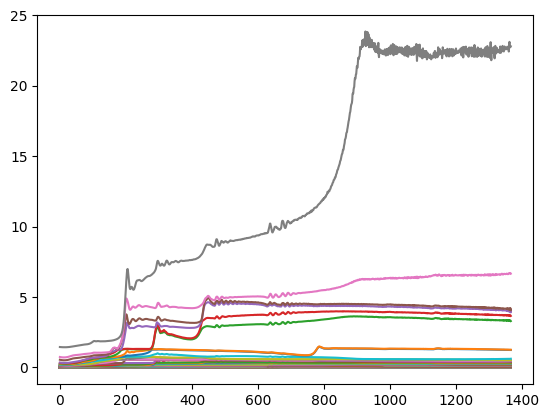

In [95]:
draw_controlabilty_dynamics("full_hippo_bdt",120)

  0%|          | 0/1895 [00:00<?, ?it/s]

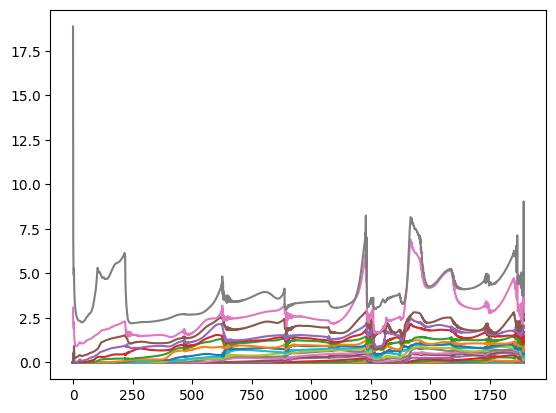

In [118]:
draw_controlabilty_dynamics("fssm_ud",120)